# Gamma Ray Bursts

Let's see if PCA gives something better.

In [1]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities\utils.py")
from Utilities import plot_settings
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

C:\Users\ricca\AppData\Local\Temp\ipykernel_1580\3973052632.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [3]:
T90  = data[6]
T90_err = data[7]
F    = data[9]
Ferr = data[10]
R    = data[11] 

In [4]:
def mask(X):
    # Elimina righe che contengono la stringa '-999'
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid]

    # Converte in float
    Y = Y.astype(float)

    # Elimina righe che contengono zero
    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y_clean = Y[mask_nonzero]

    return Y_clean, Y_clean.shape[0]

In [5]:
X = np.vstack([F, Ferr, T90, T90_err]).T
Y, size = mask(X)

I want to look at relative errors

Text(0, 0.5, 'Flux ')

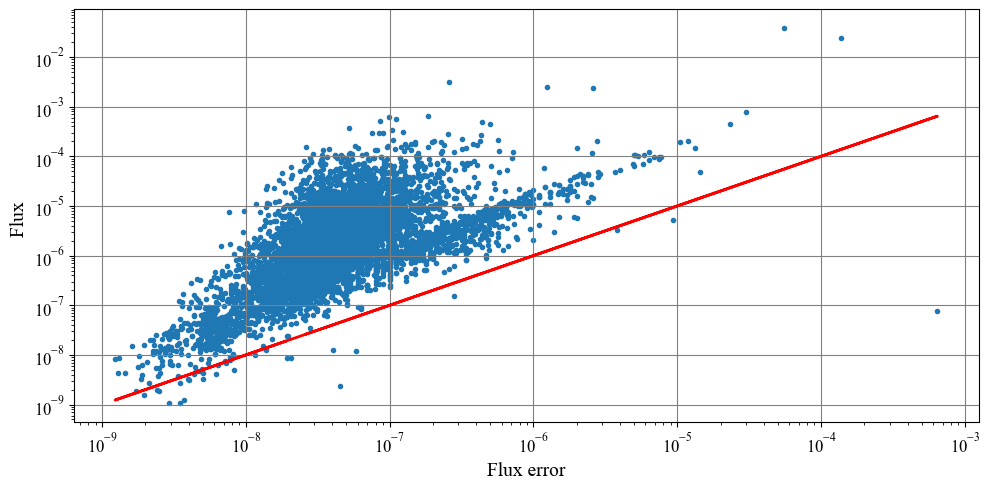

In [6]:
plt.scatter(Y.T[1], Y.T[0], marker='.')
plt.plot(Y.T[1], Y.T[1], lw=2, color='red')
plt.loglog()
plt.xlabel('Flux error')
plt.ylabel('Flux ')

Text(0, 0.5, 'T_90 ')

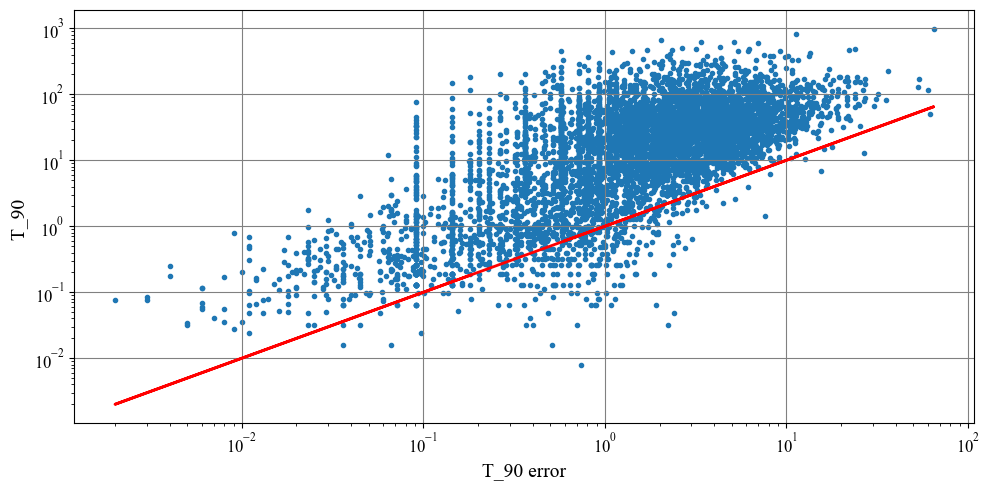

In [7]:
plt.scatter(Y.T[3], Y.T[2], marker='.')
plt.plot(Y.T[3], Y.T[3], lw=2, color='red')
plt.loglog()
plt.xlabel('T_90 error')
plt.ylabel('T_90 ')

All of the points appearing under the red line exhibit relative error bigger then 100%, thus they have to be discarded.\
I can also see a weird effect: there are points lying on lines parallel to the y axis with a $T_{90}$ value ranging from 0.1 to 100! This could be caused by the limited detector resolution. Or it could be that given a $T_{90}$ value, fluence (and thus counting statistic) can vary so much that the error attributed to GRBs with very different $T_{90}$ values could be the same.\
I'll look now into the 1D distributions of T90 and fluence.

In [19]:
def mask2(X):
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid].astype(float)

    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y = Y[mask_nonzero]

    F, Ferr, T90, T90_err, R = Y.T  
    mask_err_valid = (Ferr <= F) & (T90_err <= T90)

    Y_clean = Y[mask_err_valid]

    return Y_clean, Y_clean.shape[0]

In [20]:
X = np.vstack([F, Ferr, T90, T90_err, R]).T
Y, size = mask2(X)

In [34]:
A = np.vstack([Y.T[0], Y.T[2], Y.T[4]]).T

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [57]:
scaler = StandardScaler()
Y_scaled  =scaler.fit_transform(A)

In [58]:
from sklearn.decomposition import PCA

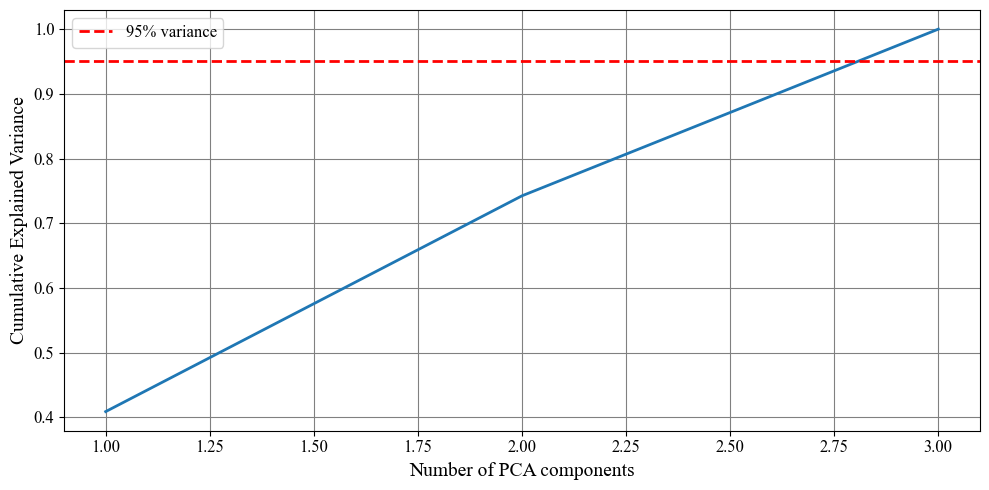

In [59]:
pca = PCA().fit(Y_scaled)
explained_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

Try with 2 components

In [125]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [135]:
pca = PCA(n_components=2, svd_solver='auto', random_state=42)
Y_pca = pca.fit_transform(Y_scaled)

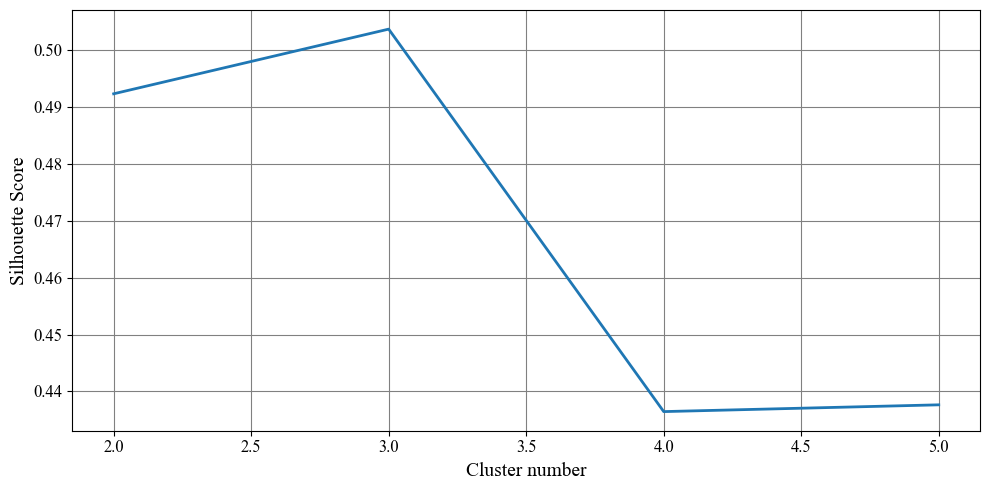

In [136]:
scores = []
components = np.linspace(2,5,4, dtype=int)
for n in components:
    labels = KMeans(n_clusters=n, random_state=42).fit_predict(Y_pca)
    score = silhouette_score(Y_pca, labels)
    scores.append(score)

plt.plot(components, scores)
plt.xlabel('Cluster number')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [137]:
labels = KMeans(n_clusters=3, random_state=42).fit_predict(Y_pca)

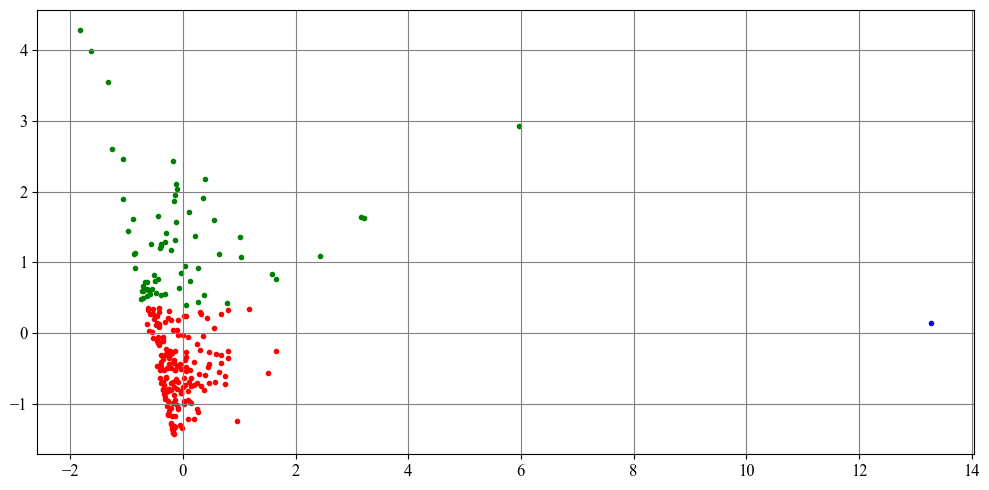

In [139]:
plt.scatter(Y_pca.T[0][labels==0], Y_pca.T[1][labels==0], marker='.', color='green')
plt.scatter(Y_pca.T[0][labels==1], Y_pca.T[1][labels==1], marker='.', color='red')
plt.scatter(Y_pca.T[0][labels==2], Y_pca.T[1][labels==2], marker='.', color='blue')

Try with 3 components in pca

In [141]:
pca = PCA(n_components=3, svd_solver='auto', random_state=42)
Y_pca = pca.fit_transform(Y_scaled)

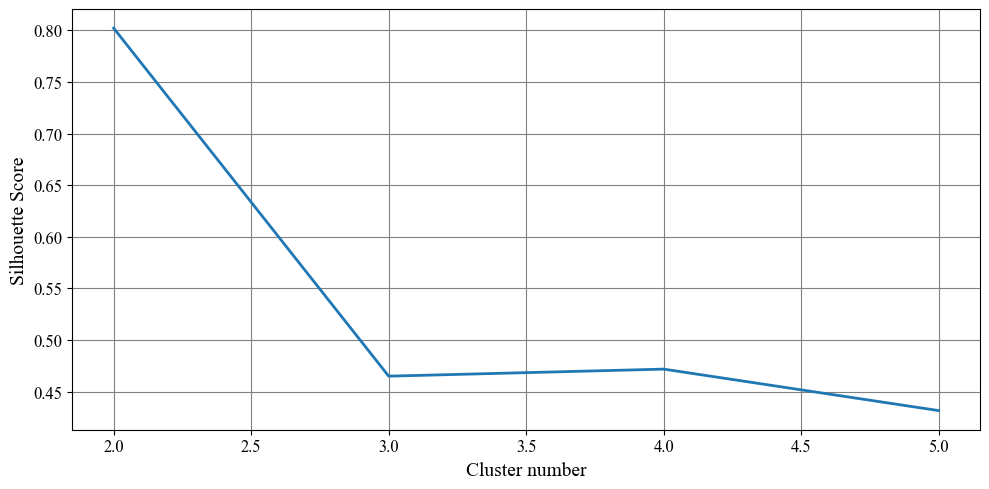

In [142]:
scores = []
components = np.linspace(2,5,4, dtype=int)
for n in components:
    labels = KMeans(n_clusters=n, random_state=42).fit_predict(Y_pca)
    score = silhouette_score(Y_pca, labels)
    scores.append(score)

plt.plot(components, scores)
plt.xlabel('Cluster number')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [144]:
labels = KMeans(n_clusters=2, random_state=42).fit_predict(Y_pca)

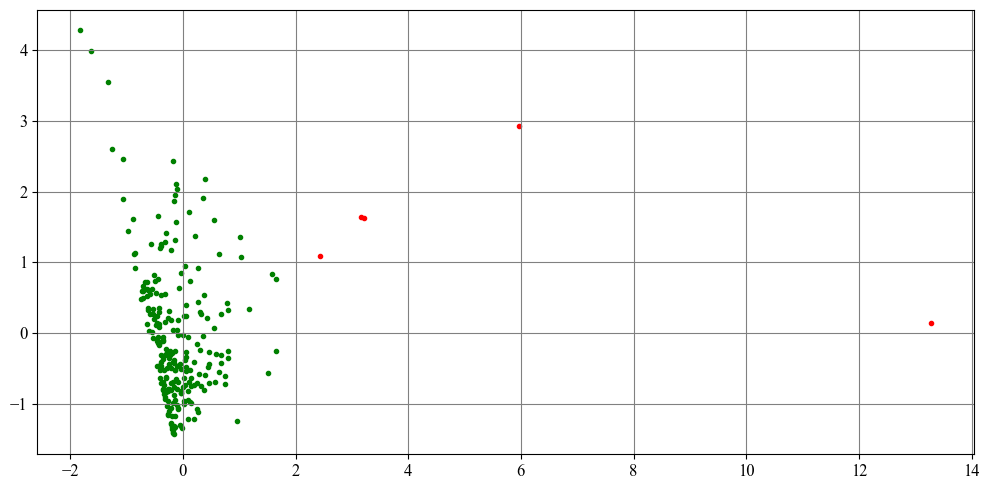

In [146]:
plt.scatter(Y_pca.T[0][labels==0], Y_pca.T[1][labels==0], marker='.', color='green')
plt.scatter(Y_pca.T[0][labels==1], Y_pca.T[1][labels==1], marker='.', color='red')

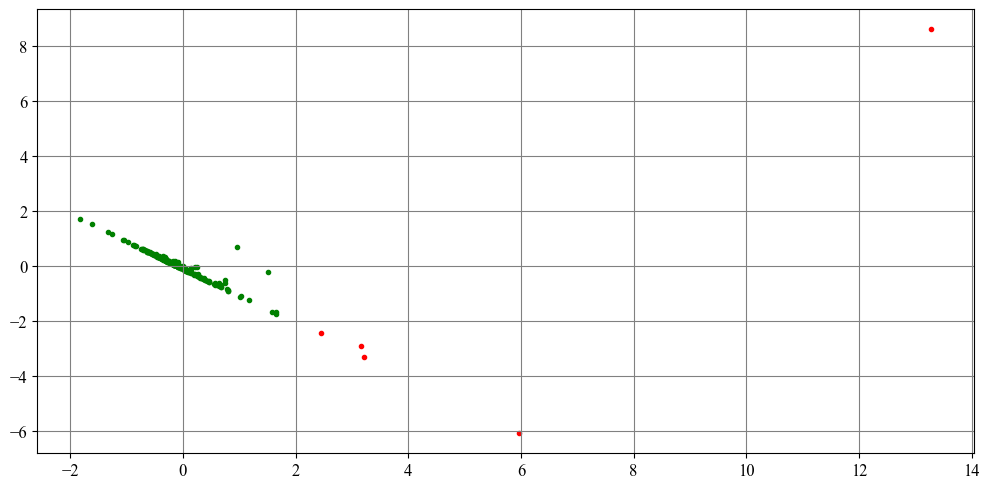

In [147]:
plt.scatter(Y_pca.T[0][labels==0], Y_pca.T[2][labels==0], marker='.', color='green')
plt.scatter(Y_pca.T[0][labels==1], Y_pca.T[2][labels==1], marker='.', color='red')

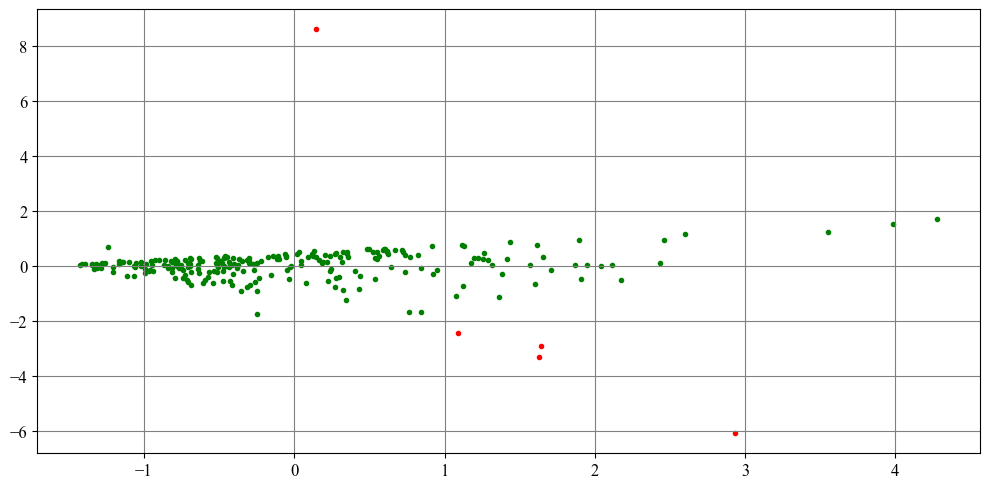

In [148]:
plt.scatter(Y_pca.T[1][labels==0], Y_pca.T[2][labels==0], marker='.', color='green')
plt.scatter(Y_pca.T[1][labels==1], Y_pca.T[2][labels==1], marker='.', color='red')

In [150]:
Y_temp = pca.inverse_transform(Y_pca)
Y_ori = scaler.inverse_transform(Y_temp)

[]

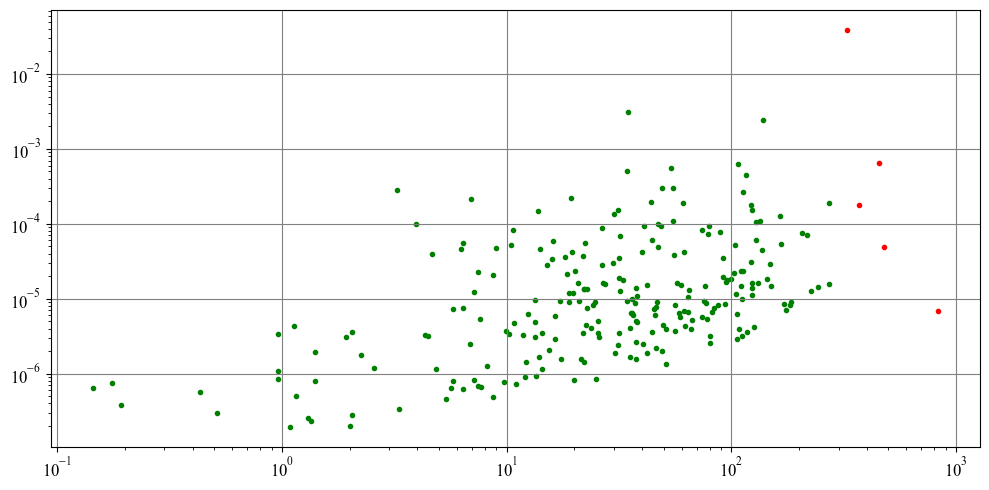

In [155]:
plt.scatter(Y_ori.T[1][labels==0], Y_ori.T[0][labels==0], marker='.', color='green')
plt.scatter(Y_ori.T[1][labels==1], Y_ori.T[0][labels==1], marker='.', color='red')
plt.loglog()